# GridSearch for model parameter optimization

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, StratifiedKFold
from functions import global_cleaner
from functions import deduplicate
from functions import timestamp_encoding
from functions import process_text_columns


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
figure_dir = '../results/figures/'
save_figures = False

In [2]:
cleaning_parameters = {
    'extract_html_metadata': True,
    'extract_url_text': True,
    'html_strip': True,
    'remove_urls': True,
    'remove_emails': True,
    'convert_currency': True,
    'normalize_unicode': True,
    'remove_non_alphanum': True,
    'remove_numbers': True,
    'lower': True,
    'remove_short': True
}
text_processor_parameters = {
    'text_length': True,
    'title_length': True,
    'article_length': True,
    'digit_density': True
}
timestamp_encoding_parameters = {
    'date_present': True,
    'year': True,
    'month': True,
    'day': True,
    'hour': True,
    'weekday': True
}

df_train = pd.read_csv('../data/development.csv', index_col='Id')

df_train = global_cleaner(df_train, cleaning_params=cleaning_parameters)

duplicate_keys = ['source', 'title', 'article']
df_train = deduplicate(df_train, duplicate_keys, 'label')

source_transformer = Pipeline(steps=[
    ('source_imputer', SimpleImputer(strategy='constant',
                                     fill_value='Unknown_source')),
    ('source_onehot', OneHotEncoder(sparse_output=True,
                                    min_frequency=4,
                                    handle_unknown='infrequent_if_exist',
                                    dtype='int8'))
])

text_transformer = ColumnTransformer(transformers=[
    ('text_tfidf', TfidfVectorizer(stop_words='english',
                                   max_features=50000,
                                   ngram_range=(1, 2),
                                   min_df=5,
                                   max_df=0.9,
                                   sublinear_tf=True), 'full_text'),
    ('text_meta_extractor', Pipeline(steps=[
        ('meta_imputer', SimpleImputer(strategy='median')),
        ('meta_scaler', MinMaxScaler())
    ]),
    [key for key in list(text_processor_parameters.keys()) if text_processor_parameters[key] is True])
])
title_article_transformer = Pipeline(steps=[
    ('title_article_combiner', FunctionTransformer(process_text_columns,
                                                   kw_args=text_processor_parameters,
                                                   validate=False)),
    ('text_feature_extractor', text_transformer)
])

page_rank_transformer = Pipeline(steps=[
    ('pagerank_imputer', SimpleImputer(strategy='most_frequent')),
    ('pagerank_scaler', MinMaxScaler())
])

timestamp_transformer = Pipeline(steps=[
    ('timestamp_encoder', FunctionTransformer(timestamp_encoding,
                                              kw_args=timestamp_encoding_parameters,
                                              validate=False)),
    ('timestamp_imputer', SimpleImputer(strategy='median')),
    ('timestamp_scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('source_preproc', source_transformer, ['source']),
    ('text_preproc', title_article_transformer, ['title', 'article']),
    ('pagerank_preproc', page_rank_transformer, ['page_rank']),
    ('timestamp_preproc', timestamp_transformer, ['timestamp'])
],
remainder='drop')

In [3]:
# 1 Logistic Regression
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
mean_f1_scores = []
std_f1_scores = []
C_param_range = [0.1, 0.5, 1, 2]

for C in C_param_range:
    clf = LogisticRegression(
        C=C,
        class_weight='balanced',
        solver='saga',
        max_iter=2000,
        random_state=SEED
)

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    scores = cross_val_score(model_pipeline, df_train, df_train['label'], cv=cv, scoring='f1_macro')

    mean_f1_scores.append(scores.mean())
    std_f1_scores.append(scores.std())

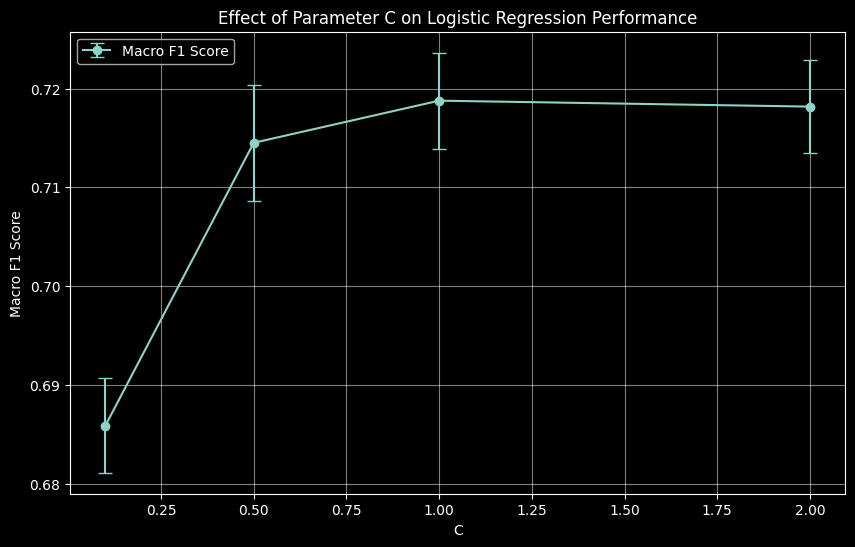

In [4]:
plt.figure(figsize=(10, 6))

plt.errorbar(C_param_range, mean_f1_scores, yerr=std_f1_scores,
             fmt='o-', capsize=5, label='Macro F1 Score')

plt.xlabel('C')
plt.ylabel('Macro F1 Score')
plt.title('Effect of Parameter C on Logistic Regression Performance')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
if save_figures:
    plt.savefig((figure_dir + 'f1_lrVsC.png'), dpi=300, bbox_inches='tight')
plt.show()

In [5]:
# 2 Linear Support Vector Classifier
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
mean_f1_scores = []
std_f1_scores = []
C_param_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

for C in C_param_range:
    clf = LinearSVC(
        class_weight='balanced',
        dual=False,
        C=C,
        random_state=SEED
)

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    scores = cross_val_score(model_pipeline, df_train, df_train['label'], cv=cv, scoring='f1_macro')

    mean_f1_scores.append(scores.mean())
    std_f1_scores.append(scores.std())

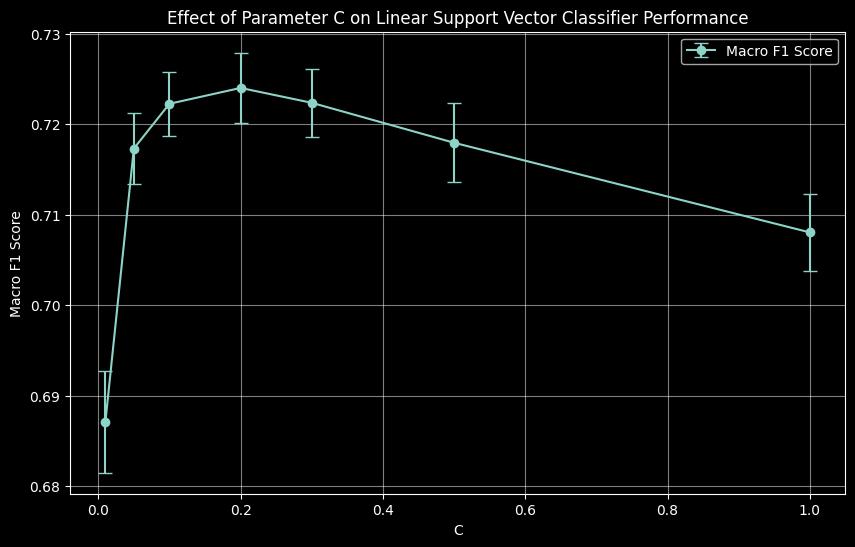

In [6]:
plt.figure(figsize=(10, 6))

plt.errorbar(C_param_range, mean_f1_scores, yerr=std_f1_scores,
             fmt='o-', capsize=5, label='Macro F1 Score')

plt.xlabel('C')
plt.ylabel('Macro F1 Score')
plt.title('Effect of Parameter C on Linear Support Vector Classifier Performance')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
if save_figures:
    plt.savefig((figure_dir + 'f1_lsvcVsC.png'), dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# 3 Multinomial Naive Bayes
mnb = MultinomialNB(
    alpha=0.5
)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
mean_f1_scores = []
std_f1_scores = []
alpha_param_range = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]

for a in alpha_param_range:
    clf = MultinomialNB(
        alpha=a
)

    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])

    scores = cross_val_score(model_pipeline, df_train, df_train['label'], cv=cv, scoring='f1_macro')

    mean_f1_scores.append(scores.mean())
    std_f1_scores.append(scores.std())

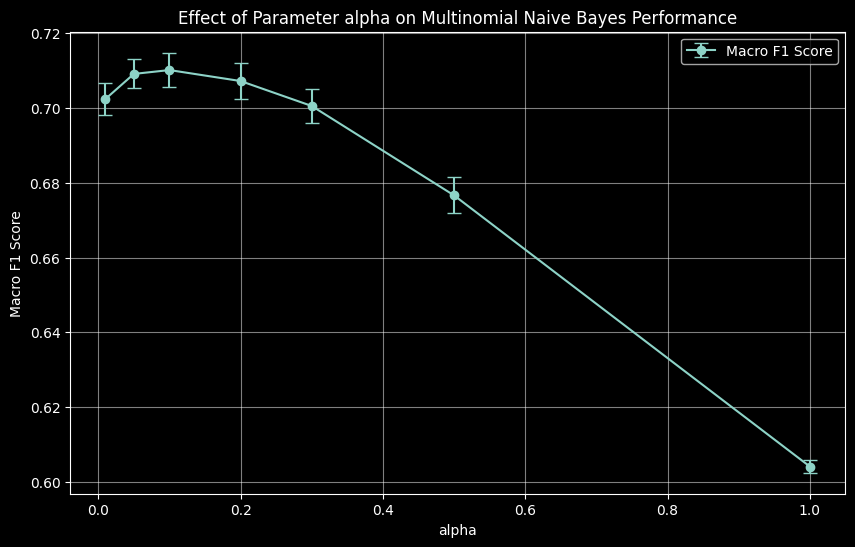

In [8]:
plt.figure(figsize=(10, 6))

plt.errorbar(alpha_param_range, mean_f1_scores, yerr=std_f1_scores,
             fmt='o-', capsize=5, label='Macro F1 Score')

plt.xlabel('alpha')
plt.ylabel('Macro F1 Score')
plt.title('Effect of Parameter alpha on Multinomial Naive Bayes Performance')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
if save_figures:
    plt.savefig((figure_dir + 'f1_NBVsA.png'), dpi=300, bbox_inches='tight')
plt.show()